# Keras Version #

#### Import Packages ####

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
import zipfile as zf

from pathlib import Path

#### Unzip Files ####

In [10]:
# one time only - Covid Chest Xray
#files = zf.ZipFile('./data/chestxray/covid_xray_images.zip','r')
#files.extractall('./data/chestxray/')
#files.close()

In [11]:
# one time only - Normal Chest Xray
#files = zf.ZipFile('./data/Covid-Keras/normal/normal_chest_xray.zip','r')
#files.extractall('./data/Covid-Keras/normal/')
#files.close()

#### sort out legit covid xrays ####

In [12]:
df = pd.read_csv('./data/chestxray/metadata.csv')
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [13]:
# convert object to str
df['finding'] = df['finding'].astype('str')
df['view'] = df['view'].astype('str')

In [14]:
# sorting out only 'COVID-19' and 'PA'
df2 = df.loc[(df['finding'] == 'COVID-19') & (df['view'] == 'PA')]

In [15]:
df2.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [16]:
df2.shape

(144, 28)

In [17]:
filename = df2['filename']
source = './data/chestxray/'
destination = './data/Covid-Keras/covid/'

In [19]:
import os
import shutil

for index, row in df2.iterrows():
    try:
        shutil.move(source + str(row['filename']), destination + str(row['filename'])) 
    
    # ignoring errors
    except:
        pass

In [ ]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required = True,
#                help="path to input dataset")
#ap.add_argument("-p", "--plot", type=str, default="plot.png", 
#                help="path to output loss/accuracy plot")
#ap.add_argument("-m", "-model", type=str, default="covid19.model", 
#                help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())

In [2]:
# learning rate, epochs, batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (ie, images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("./data/Covid-Keras"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    #extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    #load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
# convert the data and labels to Numpy arrays while scaling the pixel
# intensities to the range [0,1]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
# labelbinarizer - labels in one-vs-all fashion
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of 
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size =0.20, stratify = labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range = 15, fill_mode ="nearest")

[INFO] loading images...


In [3]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model 
# this will become the actual model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [4]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# binary_crossentropy because 2-class problem
model.compile(loss="binary_crossentropy", optimizer=opt, 
             metrics=['accuracy'])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
trainAug.flow(trainX, trainY, batch_size=BS),
steps_per_epoch=len(trainX) // BS,
validation_data = (testX, testY),
validation_steps=len(testX) // BS,
epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 9 steps, validate on 76 samples
Epoch 1/10
9/9 [==============================] - 23s 3s/step - loss: 0.8217 - accuracy: 0.5502 - val_loss: 0.6027 - val_accuracy: 0.5781
Epoch 2/10
9/9 [==============================] - 5s 551ms/step - loss: 0.6187 - accuracy: 0.6580 - val_loss: 0.4552 - val_accuracy: 0.8438
Epoch 3/10
9/9 [==============================] - 4s 465ms/step - loss: 0.6144 - accuracy: 0.6580 - val_loss: 0.3953 - val_accuracy: 0.9062
Epoch 4/10
9/9 [==============================] - 4s 431ms/step - loss: 0.5193 - accuracy: 0.7732 - val_loss: 0.3436 - val_accuracy: 0.9219
Epoch 5/10
9/9 [==============================] - 4s 407ms/step - loss: 0.4471 - accuracy: 0.7955 - val_loss: 0.3051 - val_accuracy: 0.9375
Epoch 6/10
9/9 [==============================] - 3s 382ms/step - loss: 0.3888 - accuracy: 0.8513 - val_loss:

In [5]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the 
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                           target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.93      0.86      0.89        29
      normal       0.92      0.96      0.94        47

    accuracy                           0.92        76
   macro avg       0.92      0.91      0.92        76
weighted avg       0.92      0.92      0.92        76



In [6]:
# compute the confusion matrix and use it to derive the raw accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0]+cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

# show the confusion matrix, accuracy, sensitivy, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[25  4]
 [ 2 45]]
acc: 0.9211
sensitivity: 0.8621
specificity: 0.9574


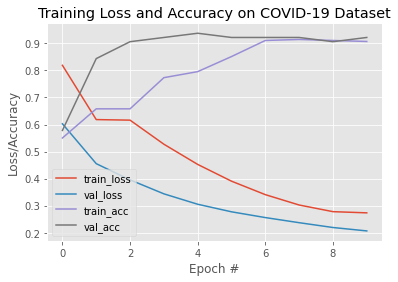

In [7]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [8]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("covid19.model", save_format="h5")

[INFO] saving COVID-19 detector model...
